In [1]:

%load_ext autoreload
%autoreload 2

from pl_trainer import LightningModule
from data_module import MNISTDataModule
from torchvision import transforms
import torch.nn as nn
import lightning.pytorch as pl
import pandas as pd
import matplotlib.pyplot as plt
import torch

pl.seed_everything(42)

Seed set to 42


42

# Setting up Hyperparameters

In [19]:
lr = 0.002
batch_size = 64
max_epochs = 5

# Defining Model Architecture 

In [25]:
def create_model():
    """
        Initializes the model. Edit the code below if you would like to change the model.
    """
    model = nn.Sequential(
        nn.Flatten(),  # Flattens the image from shape (batch_size, C, Height, width) to (batch_size, C*height*width)
        nn.Linear(28*28*1, 64), 
        nn.ReLU(),
        nn.Linear(64, 10),
        # No need to include softmax, as this is already combined in the loss function
    )
    return model

# Initialize the model, data module, and trainer
pl_model = LightningModule(model = create_model(), lr=lr)

# Setting up Dataloaders and Transformations

In [26]:
my_transforms = transforms.Compose([
            transforms.ToTensor(),

            transforms.Normalize((0.5,), (0.5,))
        ])


mnist_data = MNISTDataModule(batch_size=batch_size, transforms=my_transforms)

# Train Model

In [27]:
# Initialize CSVLogger
csv_logger = pl.loggers.CSVLogger(save_dir='logs/', name='mnist_logs', version=0)

# Set up the trainer
trainer = pl.Trainer(max_epochs=max_epochs, logger=csv_logger, check_val_every_n_epoch=1, enable_checkpointing=False)

# Train the model
trainer.fit(pl_model, mnist_data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/vegardhoug/NTNU/5H25/TDT4195_Visual_computing_fundementals/visual-computing-ip/.venv/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/mnist_logs/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!

  | Name    | Type               | Params | Mode 
-------------------------------------------------------
0 | model   | Sequential         | 50.9 K | train
1 | loss_fn | CrossEntropyLoss   | 0      | train
2 | acc_fn  | MulticlassAccuracy | 0      | train
-------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


/home/vegardhoug/NTNU/5H25/TDT4195_Visual_computing_fundementals/visual-computing-ip/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/vegardhoug/NTNU/5H25/TDT4195_Visual_computing_fundementals/visual-computing-ip/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 937/937 [00:10<00:00, 91.07it/s, v_num=0, val_acc=0.894, val_loss=0.389] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 937/937 [00:10<00:00, 91.06it/s, v_num=0, val_acc=0.894, val_loss=0.389]


# Plot Results

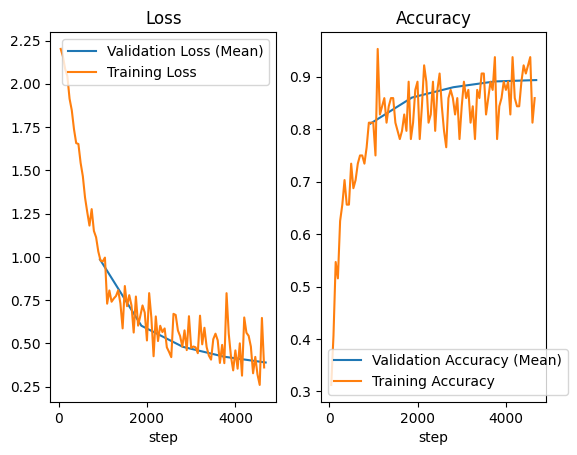

Final validation loss 0.3892
Final validation accuracy 0.8937


In [28]:
df = pd.read_csv('logs/mnist_logs/version_0/metrics.csv')

# Create a figure and axes objects
fig, ax = plt.subplots(1,2)

# Plot 'val_loss' on the axes
df.dropna(subset=['val_loss']).plot(x='step', y='val_loss', ax=ax[0], label='Validation Loss (Mean)')
# Plot 'train_loss' on the same axes
df.dropna(subset=['train_loss']).plot(x='step', y='train_loss', ax=ax[0], label='Training Loss')

# Plot 'val_loss' on the axes
df.dropna(subset=['val_acc']).plot(x='step', y='val_acc', ax=ax[1], label='Validation Accuracy (Mean)')
# Plot 'train_loss' on the same axes
df.dropna(subset=['train_acc']).plot(x='step', y='train_acc', ax=ax[1], label='Training Accuracy')

ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
plt.show()

print("Final validation loss", round(df['val_loss'].iloc[-1], 4))
print("Final validation accuracy", round(df['val_acc'].iloc[-1], 4))

# Plot weights

Shape of weights: torch.Size([10, 784])


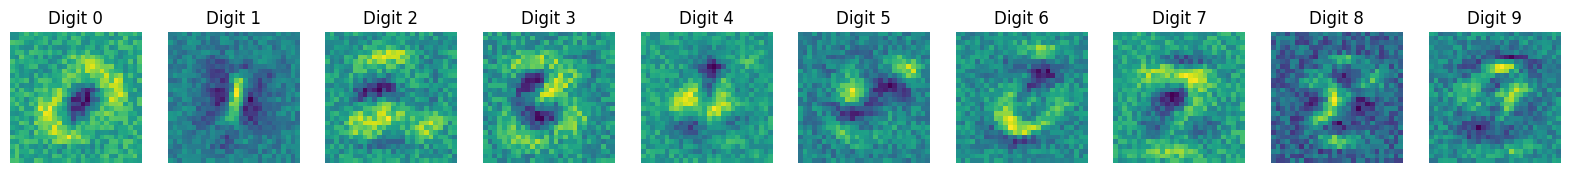

In [24]:
def plot_weights(weight):
    """
        Plots the weights of the model. Only works for models with a single linear layer.
        returns the shape of the reshaped weights as torch.Size
    """

    fig, axs = plt.subplots(1, 10, figsize=(20, 2))
    
    reshaped_weight = weight.view(10, 28, 28)
    
    for i in range(10):
        axs[i].imshow(reshaped_weight[i], cmap='viridis')
        axs[i].axis('off')
        axs[i].set_title(f"Digit {i}")
    
    plt.show()
    return reshaped_weight.shape


weight = list(pl_model.model.children())[-1].state_dict()["weight"].cpu().data
print("Shape of weights:", weight.shape)
if weight.shape == torch.Size([10, 784]):
    plot_weights(weight)
else:
    print("This function only works for models with a single linear layer.")
